# Prediction using Xgboost

##### loading libraries

In [ ]:
library(data.table)
library(caret)
library(pROC)

##### loading datasets

In [2]:
load("../data_processed/projetDataBase.Rda")
projetTrain    = sub.projetTrain.base
projetValid    = sub.projetValid.base

##### making subsets for train and test of our TRAIN DATA

In [3]:
set.seed(30)
split = sample(nrow(projetTrain), floor(0.5*nrow(projetTrain)))
sub.train = projetTrain[split,]
sub.test  = projetTrain[-split,]

##### defining train control and control grid

In [20]:
cv.ctrl <- trainControl(method = "repeatedcv", repeats = 1,number = 3, 
                        summaryFunction = twoClassSummary,
                        classProbs = TRUE,
                        allowParallel=T)

xgb.grid <- expand.grid(nrounds          = 1000,
                        eta              = c(0.01,0.05,0.1),
                        max_depth        = c(2,4,6,8,10,14),
                        gamma            = 1,
                        colsample_bytree = 1,    #default=1
                        min_child_weight = 1     #default=1
                        )

##### Computing the Xgboost model

In [21]:
xgb.model <-train(target~.,
                     data=sub.train,
                     method="xgbTree",
                     trControl=cv.ctrl,
                     tuneGrid=xgb.grid,
                     verbose=T,
                     metric="Kappa",
                     nthread =4
)

Warning message in train.default(x, y, weights = w, ...):
"The metric "Kappa" was not in the result set. ROC will be used instead."

##### model description

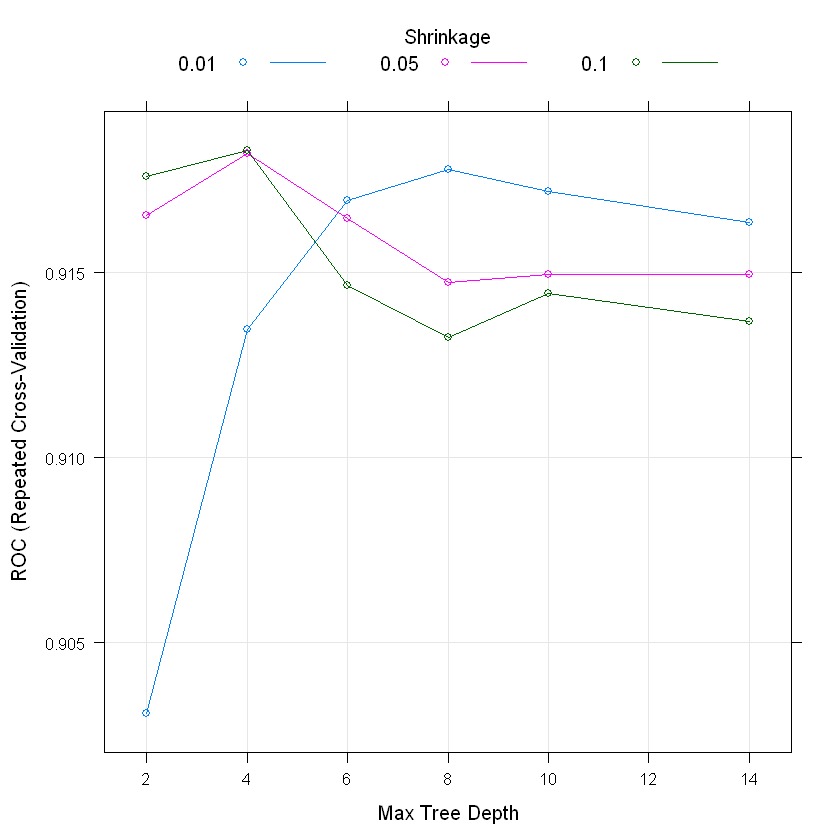

In [27]:
plot(xgb.model)

In [23]:
xgb.model

eXtreme Gradient Boosting 

25690 samples
  129 predictor
    2 classes: 'KO', 'OK' 

No pre-processing
Resampling: Cross-Validated (3 fold, repeated 1 times) 
Summary of sample sizes: 17126, 17127, 17127 
Resampling results across tuning parameters:

  eta   max_depth  ROC        Sens       Spec     
  0.01   2         0.9030983  0.8456898  0.7888050
  0.01   4         0.9134567  0.8512008  0.8006374
  0.01   6         0.9169621  0.8551456  0.8052519
  0.01   8         0.9177982  0.8560738  0.8067896
  0.01  10         0.9171936  0.8570020  0.8005196
  0.01  14         0.9163464  0.8601346  0.7937754
  0.05   2         0.9165599  0.8524771  0.8123499
  0.05   4         0.9182304  0.8584523  0.8051338
  0.05   6         0.9164667  0.8604246  0.7933018
  0.05   8         0.9147457  0.8615269  0.7813526
  0.05  10         0.9149400  0.8623970  0.7822986
  0.05  14         0.9149534  0.8618749  0.7825359
  0.10   2         0.9175930  0.8550296  0.8124684
  0.10   4         0.9183025  0.85

##### Prediction on test subset

In [24]:
result.predicted.prob <- predict(xgb.model, sub.test , type="prob") # Prediction

##### AUC curve


Call:
roc.default(response = sub.test$target, predictor = result.predicted.prob$OK)

Data: result.predicted.prob$OK in 17265 controls (sub.test$target KO) < 8426 cases (sub.test$target OK).
Area under the curve: 0.9213

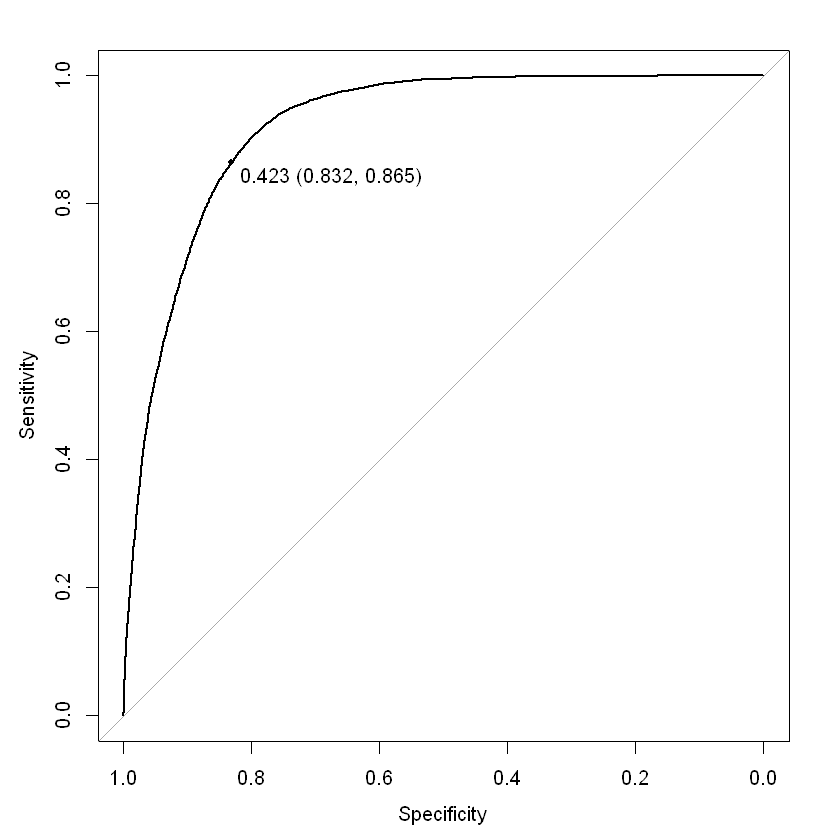

In [25]:
result.roc <- roc(sub.test$target, result.predicted.prob$OK) # Draw ROC curve.
plot(result.roc, print.thres="best", print.thres.best.method="closest.topleft")

In [26]:
result.coords <- coords(result.roc, "best", best.method="closest.topleft", ret=c("threshold", "accuracy"))
print(result.coords)#to get threshold and accuracy

threshold  accuracy 
0.4226655 0.8426686 


##### Saving model 

In [28]:
save(xgb.model, file="xgb.Rdata")

##### generating the response for the validation subset

In [29]:
result.predicted.prob.valid <- predict(xgb.model, projetValid , type="prob") # Prediction on validation subset
projetValid$Id = as.character(projetValid$Id)
validation.results = cbind(projetValid[,"Id",with=FALSE],result.predicted.prob.valid)
write.csv(validation.results, file = "validation_results.csv")